<a href="https://colab.research.google.com/github/julia-walker/ML_Final_Project/blob/main/ML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Setup


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import matplotlib as plt 
import pandas as pd


# Extra imports for data pre- processing
!pip install rasterio
import rasterio 

!pip install geopandas
import geopandas as gpd

!pip install --upgrade pyshp

!pip install --upgrade shapely

!pip install --upgrade descartes

!pip install --upgrade rtree

from __future__ import print_function

from osgeo import ogr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 263 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 16.6 MB 51.7 MB/s 
     |████████████████████████████████| 7.8 MB 67.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 


Pre-processing of Training Data

In [2]:
#Code adapted from "Importing and Using Vector data-OGR library" tutorial by Chris Holden 
#https://ceholden.github.io/open-geo-tutorial/python/chapter_4_vector.html

#download training polygon data from google drive
!gdown 1eU1u_FC2Y1qgH-5pCz0qQT1iwXArHXsL
!gdown 1Avi9D_HhnP-ZH_VJLEd9ckeInoAZ_X7a
!gdown 1APoauolAvB-11SavW1NMttRTSt_LqWs5
!gdown 15l9P6wHhxF89DMPSF3xX91ktp3jIlMXT


# Open the dataset from the file
dataset = ogr.Open('./polygons_SA.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not dataset:
    print('Error: could not open dataset')



Downloading...
From: https://drive.google.com/uc?id=1eU1u_FC2Y1qgH-5pCz0qQT1iwXArHXsL
To: /content/polygons_SA.shp
100% 8.42k/8.42k [00:00<00:00, 1.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Avi9D_HhnP-ZH_VJLEd9ckeInoAZ_X7a
To: /content/polygons_SA.prj
100% 400/400 [00:00<00:00, 539kB/s]
Downloading...
From: https://drive.google.com/uc?id=1APoauolAvB-11SavW1NMttRTSt_LqWs5
To: /content/polygons_SA.dbf
100% 721/721 [00:00<00:00, 97.1kB/s]
Downloading...
From: https://drive.google.com/uc?id=15l9P6wHhxF89DMPSF3xX91ktp3jIlMXT
To: /content/polygons_SA.shx
100% 140/140 [00:00<00:00, 205kB/s]


In [3]:
#download Vallon de Nant study area image from google drive
!gdown 12KHX15jBRWnlgQG9orqhCb_J-fWLWXde

Downloading...
From: https://drive.google.com/uc?id=12KHX15jBRWnlgQG9orqhCb_J-fWLWXde
To: /content/SA_Raster.tif
100% 25.2M/25.2M [00:00<00:00, 205MB/s]


In [4]:

#Code adapted from "Importing and Using Vector data-OGR library" tutorial by Chris Holden 
#https://ceholden.github.io/open-geo-tutorial/python/chapter_4_vector.html

#converting training polygons into raster with the same extent as study area raster
%%bash

# Explanation of switches:
# -a ==> write values from the"id" attribute of the shapefile
# -layer ==> the layer name of our shapefile
# -of ==> Output raster file format
# -a_srs ==> output spatial reference system string
# -a_nodata ==> NODATA value for output raster
# -te ==> target extent which matches the raster we want to create the ROI image for
# -tr ==> target resolution, 30 x 30m
# -ot Byte ==> Since we only have values 0 - 5, a Byte datatype is enough

gdal_rasterize -a "id" \
    -l polygons_SA \
    -of "GTiff" \
    -a_srs "+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs" \
    -a_nodata 5 \
    -te 351066 5117925 355542 5123967 \
    -tr 3 3 \
    -ot Byte \
    ./polygons_SA.shp ./training_data.gtif


0...10...20...30...40...50...60...70...80...90...100 - done.


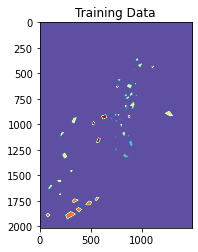

In [5]:

#Code adapted from "classification of land cover" tutorial by Chris Holden 
#https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html 

#Generating training dataset
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('./SA_Raster.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('./training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display training data raster
plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.show()


In [6]:
#Code adapted from "classification of land cover" tutorial by Chris Holden 
#https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html 

#Pairing X (spectral bands) with Y(land cover class labels) for training data

# How many training data samples?
n_samples = (roi < 5).sum()
print('We have {n} samples'.format(n=n_samples))


# What are our classification labels?
labels = np.unique(roi[roi < 5])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     

X = img[roi < 5, :] 
y = roi[roi < 5]


print('X matrix is sized: {sz}'.format(sz=X.shape))
print('y array is sized: {sz}'.format(sz=y.shape))

We have 30362 samples
The training data include 5 classes: [0 1 2 3 4]
X matrix is sized: (30362, 4)
y array is sized: (30362,)


Implementing Machine Learning Algorithms with Default Hyperparameters


In [7]:
#code for this section adopted from Tom Beucler's Machine Learning for Earth and Environmnetal Science Course
#https://github.com/tbeucler/2022_ML_EES/tree/main/Labs

#Split training data into training and test sets

from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [8]:
#fit training data to random forest algorithm

from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 100 trees (default)
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

Accuracy: 0.967072769180112


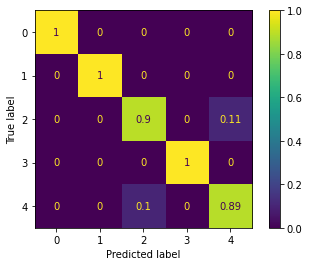

In [9]:
#test random forest algorithm on test set and compute accuracy scores and confusion matrx
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
###
y_pred = rf.predict(X_test) #prediction on the test set
accuracy = accuracy_score(y_test, y_pred) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='pred') # Get a confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize matrix
disp.plot()



     

In [10]:
#test random forest algorithm on validation set and compute accuracy scores 
y_pred2 = rf.predict(x_val) #prediction on the test set
accuracy = accuracy_score(y_val, y_pred2) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_val, y_pred2))

Accuracy: 0.9681598594642072


In [11]:
#fit training data to SVM algorithm

from sklearn import svm
sv = svm.SVC()
sv.fit(X_train, y_train) #fit to training data
y_pred_svm = sv.predict(X_test) #predict on test data

Accuracy: 0.9446822522225881


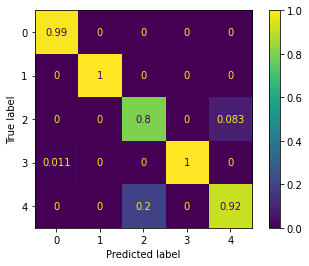

In [12]:
# Accuracy score and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

accuracy_svm = accuracy_score(y_test, y_pred_svm) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm, normalize='pred') # Get a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize matrix
disp.plot()

In [75]:
#repeat prediction and accuracy for validation set
y_pred3 = sv.predict(x_val) #prediction on the test set
accuracy = accuracy_score(y_val, y_pred3) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_val, y_pred3))

Accuracy: 0.9523495827843654


Implementing Machine Learning Algorithms with Best Hyperparameters after Hyperparameter GridSearch

In [53]:
#Hyperparameter search for Random Forest
#source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import GridSearchCV
###
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Creation of the parameter grid based on the results of random search
param_grid = {'n_estimators': n_estimators, 'max_features': max_features}
# Random grid search for best hyperparameters: random search
gsrf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1) #searches grid for best parameters
gsrf.fit(X_train, y_train) # Fit the grid search to the data

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True), n_jobs=-1,
             param_grid={'max_features': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             verbose=2)

In [55]:
#return best number of trees (n_estimators) and maximum features to use 
best_grid = gsrf.best_params_
best_grid
     

{'max_features': 3, 'n_estimators': 300}

In [65]:
#prediction based on best parameters for validation and test set 
y_pred_test = gsrf.predict(X_test)
y_pred_val = gsrf.predict(x_val)
# Calculate the accuracy of the best model over the training and test sets
from sklearn.metrics import accuracy_score
print(f'Accuracy over test set: {(accuracy_score(y_test,y_pred_test)):.2%}'
f'Accuracy over validation set: {(accuracy_score(y_val,y_pred_val)):.2%}')

Accuracy over training set: 100.00% 
Accuracy over test set: 96.58%Accuracy over validation set: 96.64%


In [67]:
#Source: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000]} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) #searches parameters for best fit 
  
# fitting the model for grid search
grid.fit(X_train, y_train)
     

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............................C=0.1;, score=0.931 total time=   3.0s
[CV 2/5] END .............................C=0.1;, score=0.922 total time=   3.0s
[CV 3/5] END .............................C=0.1;, score=0.927 total time=   3.3s
[CV 4/5] END .............................C=0.1;, score=0.920 total time=   3.0s
[CV 5/5] END .............................C=0.1;, score=0.933 total time=   3.0s
[CV 1/5] END ...............................C=1;, score=0.950 total time=   2.2s
[CV 2/5] END ...............................C=1;, score=0.948 total time=   2.5s
[CV 3/5] END ...............................C=1;, score=0.950 total time=   2.3s
[CV 4/5] END ...............................C=1;, score=0.944 total time=   2.2s
[CV 5/5] END ...............................C=1;, score=0.948 total time=   2.2s
[CV 1/5] END ..............................C=10;, score=0.955 total time=   2.0s
[CV 2/5] END ..............................C=10;,

GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100, 1000]},
             verbose=3)

In [68]:
print(grid.best_params_)

{'C': 1000}


In [69]:
y_pred_train2 = grid.predict(X_train)
y_pred_test2 = grid.predict(X_test)
y_pred_val2 = grid.predict(x_val)
# Calculate the accuracy of the best model over the training and test sets
from sklearn.metrics import accuracy_score
print(f'Accuracy over test set: {(accuracy_score(y_test,y_pred_test)):.2%}'
f'Accuracy over validation set: {(accuracy_score(y_val,y_pred_val)):.2%}')


Accuracy over training set: 100.00% 
Accuracy over test set: 96.58%Accuracy over validation set: 96.64%
